<h1>Temperature Control v1 Model Training</h1>

<h3>Load Libraries</h3>

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

<h3>Data Loading and Preprocessing</h3>

In [25]:
# Load the dataset
df = pd.read_csv('data/2023_06_21_15_16_Chronograf_Data.csv')  # Replace 'your_dataset.csv' with the path to your dataset

# Convert the time column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Extract year, month, day, hour, and minute as separate features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute

# Selecting the target variable and features (adjust as necessary)
features = ['year', 'month', 'day', 'hour', 'minute']  # Add other features if needed
target = 'temperature'  # Adjust this to your target variable

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df[features])

# Preparing the data for LSTM
def create_sequences(features, target, seq_length):
    xs = []
    ys = []
    for i in range(len(features)-seq_length-1):
        x = features[i:(i+seq_length)]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(scaled_features, df[target].values, seq_length)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], seq_length, len(features)))
X_test = X_test.reshape((X_test.shape[0], seq_length, len(features)))


In [28]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, len(features))),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=20, validation_split=0.2)



Epoch 1/20
37992/37992 [==============================] - 118s 3ms/step - loss: 3.0083 - val_loss: 0.1019
Epoch 2/20
37992/37992 [==============================] - 113s 3ms/step - loss: 0.3294 - val_loss: 0.0723
Epoch 3/20
37992/37992 [==============================] - 113s 3ms/step - loss: 0.1598 - val_loss: 0.1221
Epoch 4/20
37992/37992 [==============================] - 113s 3ms/step - loss: 0.1172 - val_loss: 0.0548
Epoch 5/20
37992/37992 [==============================] - 120s 3ms/step - loss: 0.1382 - val_loss: 0.0507
Epoch 6/20
37992/37992 [==============================] - 116s 3ms/step - loss: 0.0995 - val_loss: 0.0442
Epoch 7/20
37992/37992 [==============================] - 115s 3ms/step - loss: 0.0597 - val_loss: 0.0398
Epoch 8/20
37992/37992 [==============================] - 112s 3ms/step - loss: 0.0615 - val_loss: 0.0324
Epoch 9/20
37992/37992 [==============================] - 113s 3ms/step - loss: 0.0507 - val_loss: 0.0300
Epoch 10/20
37992/37992 [=====================

In [29]:
# Use model.evaluate() on your test data to evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


11873/11873 [==============================] - 12s 1ms/step - loss: 0.0260
Test Loss: 0.025993863120675087


In [30]:
# Predictions
predictions = model.predict(X_test)

# You can compare 'predictions' with 'y_test' to see how well your model is performing


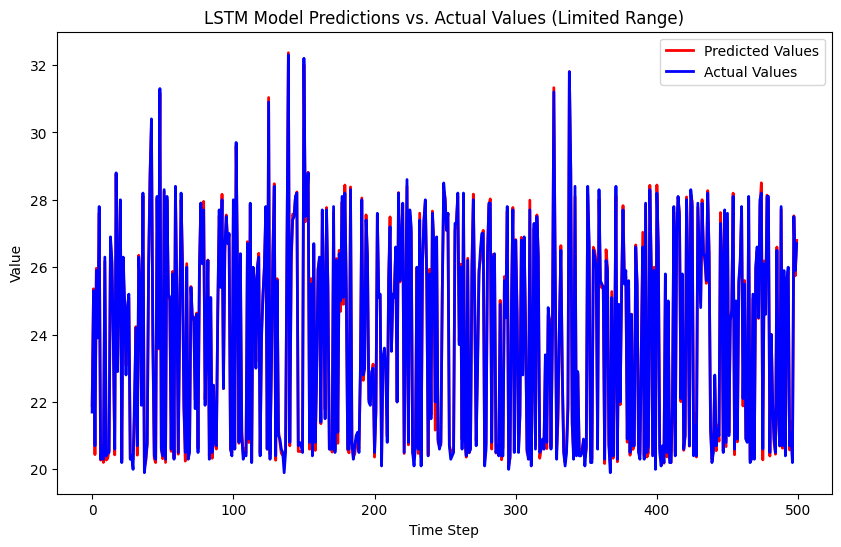

In [36]:
import matplotlib.pyplot as plt

# Define the range of time steps to visualize
start_index = 0  # Start index of the plot
end_index = 50  # End index of the plot (adjust this value as needed)

# Plotting with a limited range of time steps
plt.figure(figsize=(10, 6))
plt.plot(predictions[start_index:end_index], label='Predicted Values', color='red', linewidth=2)
plt.plot(y_test[start_index:end_index], label='Actual Values', color='blue', linewidth=2)
plt.title('LSTM Model Predictions vs. Actual Values (Limited Range)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


CUT


In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  # Adjust based on your model's needs
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data=(testX, testY))

In [ ]:
# Making predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverting predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# Assuming 'testPredict' are your model's predictions and 'testY' are the actual values
# And assuming 'test' is your scaled test dataset, used for aligning the time axis in the plot

# Invert scaling for actual values to plot them in their original scale
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time axis for the test dataset, adjust as per your dataset's datetime range
time_axis = pd.date_range(start=df.index[train_size], periods=len(testPredict), freq='D')  # Adjust the frequency ('D' for days)

plt.figure(figsize=(15, 6))
plt.plot(time_axis, testY_actual, label='Actual Temperature', color='blue')
plt.plot(time_axis, testPredict, label='Predicted Temperature', color='red', alpha=0.7)
plt.title('Temperature Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Calculate MAE and RMSE
mae = mean_absolute_error(testY_actual, testPredict)
rmse = sqrt(mean_squared_error(testY_actual, testPredict))

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
